In [ ]:
from code.cleaner import preprocess

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import PCA

In [2]:
sentiments = pd.read_csv('./data/judge-1377884607_tweet_product_company.csv',encoding='ISO-8859-1')

In [3]:
#changing column names and dropping the one null entry in tweet_text
sentiments['product'] = sentiments['emotion_in_tweet_is_directed_at']
sentiments['sentiment'] = sentiments['is_there_an_emotion_directed_at_a_brand_or_product']

sentiments.drop(axis=1, columns=['emotion_in_tweet_is_directed_at','is_there_an_emotion_directed_at_a_brand_or_product'], inplace=True)

sentiments.dropna(subset=['tweet_text'],inplace=True)

In [4]:
#dropping "I can't tell" for initial model. To be used as testing data later
sentiments = sentiments[sentiments['sentiment'] != "I can't tell"]

In [5]:
sentiments['product'].value_counts()

iPad                               942
Apple                              659
iPad or iPhone App                 470
Google                             429
iPhone                             296
Other Google product or service    292
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

In [7]:
sentiments['sentiment'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: sentiment, dtype: int64

In [12]:
tokenizer = RegexpTokenizer(r"([@#]?[a-zA-Z]+(?:’[a-z]+)?)")

stopwords_list = stopwords.words('english')

specific_words = ['@mention','link','sxsw','#sxsw','@sxsw', 'google',
                 'iphone', 'ipad', 'android', 'app', 'apple', 'rt', 
                 'quot', 'store', 'new', 'austin']

stopwords_list.extend(specific_words)

lemmer = WordNetLemmatizer()

In [13]:
def preprocess_text(text, tokenizer, stopwords_list, lemmer):
    # Standardize case (lowercase the text)
    lower_t = text.lower()
    
    # Tokenize text using `tokenizer`
    tokens = tokenizer.tokenize(lower_t)
    
    # Remove stopwords using `stopwords_list`
    stopped_tokens = [token for token in tokens if token not in stopwords_list]
    
    # Stem the tokenized text using `stemmer`
    lems = [lemmer.lemmatize(token) for token in stopped_tokens]
    
    
    # Return the preprocessed text
    return lems


text_data = sentiments.tweet_text.apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, lemmer))



In [14]:
data = sentiments.copy()

data['preprocessed_text'] = text_data

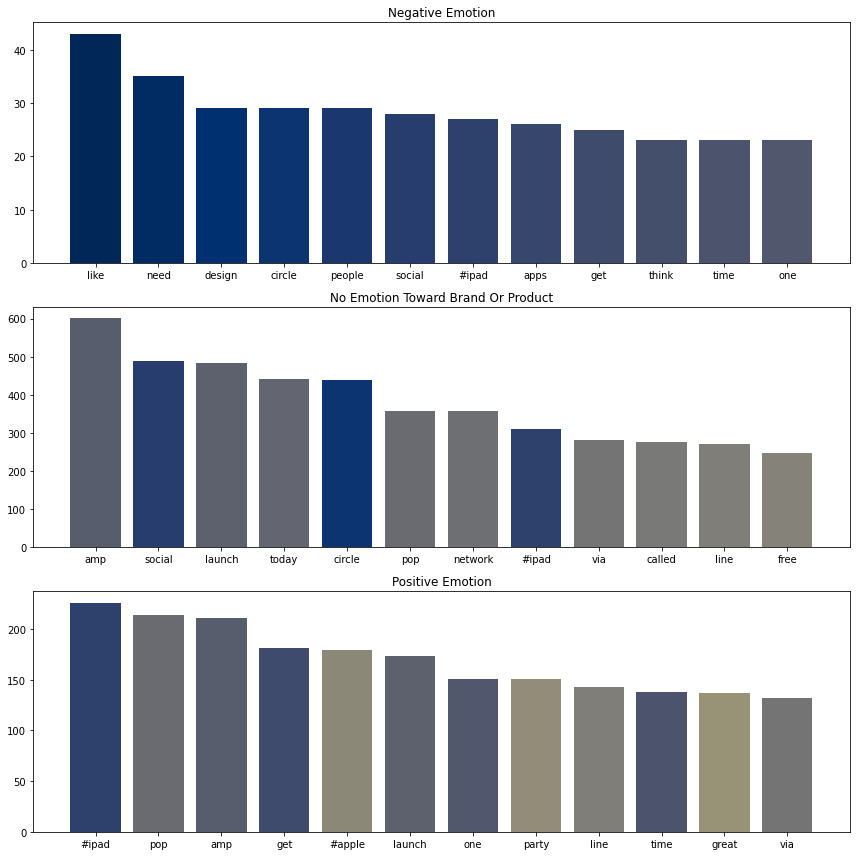

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up figure and axes
fig, axes = plt.subplots(nrows=3, figsize=(12, 12))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}
# Establish color palette to pull from
# (If you get an error message about popping from an empty list, increase this #)
color_palette = sns.color_palette('cividis', n_colors=38)

# Creating a plot for each unique sentiment
data_by_sentiment = [y for _, y in data.groupby('sentiment', as_index=False)]
for idx, sentiment_df in enumerate(data_by_sentiment):
    # Find top 10 words in this genre
    all_words_in_tweet = sentiment_df.preprocessed_text.explode()
    top_10 = all_words_in_tweet.value_counts()[:12]
    
    # Select appropriate colors, reusing colors if words repeat
    colors = []
    for word in top_10.index:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[idx]
    ax.bar(top_10.index, top_10.values, color=colors)
    ax.set_title(sentiment_df.iloc[0].sentiment.title())
    
fig.tight_layout()

# Deciding on Vectorizer

In [16]:
from sklearn.model_selection import train_test_split

# Convert token lists to strings
data["joined_preprocessed_text"] = data["preprocessed_text"].str.join(" ")

# Create train test split
X_train, X_test, y_train, y_test = train_test_split(
    data["joined_preprocessed_text"], data.sentiment, test_size=0.3, random_state=2021)

X_train

1302    wishing see rumored demo social network circle...
7778    really launching social medium site anyone els...
8676    kind funny sad release line longer party line ...
4110                              #tech save set open pop
6195    join actsofsharing com tonight person friend c...
                              ...                        
6208    st lcd cinema display facetime facetime bar li...
4008    heat tracker cool heatmap overlay foursquare e...
2716    anyone seen pop store like cnn restaurant plus...
1169                  whrrl live marketplace get hot time
6307     mayer think simplicity lot developing product jr
Name: joined_preprocessed_text, Length: 6255, dtype: object

## 1.  Fitting a Count Vectorizer

In [17]:
# CodeGrade step3
# Import the CountVectorizer object from sklearn

from sklearn.feature_extraction.text import CountVectorizer

# Create a `vectorizer` instance
vectorizer = CountVectorizer()

# Fit the vectorizer to the training data
vectorizer.fit(X_train)

CountVectorizer()

In [18]:
X_train_vectorized = vectorizer.transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

C:\Users\raxmo\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


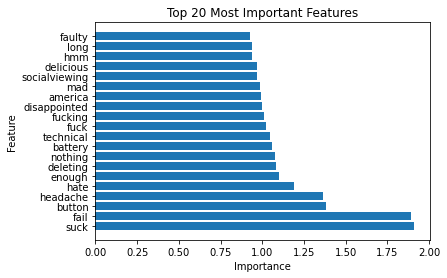

In [34]:
# For example, using logistic regression:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_vectorized, y_train)
feature_importances = lr.coef_[0]

feature_importances_sorted = sorted(zip(feature_importances, vectorizer.get_feature_names()), reverse=True)

N = 20
top_features = [f[1] for f in feature_importances_sorted[:N]]
top_importances = [f[0] for f in feature_importances_sorted[:N]]

plt.barh(np.arange(len(top_features)), top_importances)
plt.yticks(np.arange(len(top_features)), top_features)
plt.title('Top {} Most Important Features'.format(N))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Fitting a Naive Bayes Model

In [24]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

nb.fit(X_train_vectorized, y_train)

MultinomialNB()

$$
\begin{bmatrix}
 & \text{Negative} & \text{Neutral} & \text{Positive} \\
\text{Negative} & \text{True-Neg} & \text{FNeu-Neg} & \text{FP-Neg} \\
\text{Neutral} & \text{False-Neg-Neu} & \text{True-Neu} & \text{False-P-Neu} \\
\text{Positive} & \text{False-Neg} & \text{False-Neu-Pos} & \text{TP} \\
\end{bmatrix}
$$

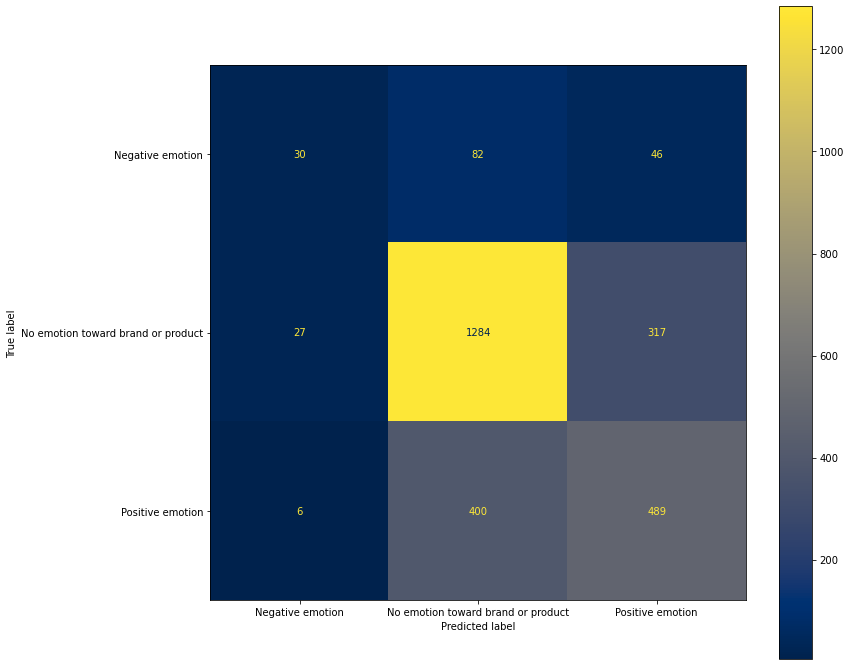

In [25]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(nb, X_test_vectorized, y_test, ax=ax, cmap="cividis");

## 2. Fitting a TfidVectorizer

In [27]:
vectorizer2 = TfidfVectorizer()

# Fit
vectorizer2.fit(X_train)

# Transform
tf_idf_train = vectorizer2.transform(X_train)

tf_idf_test = vectorizer2.transform(X_test)

### Testing on model

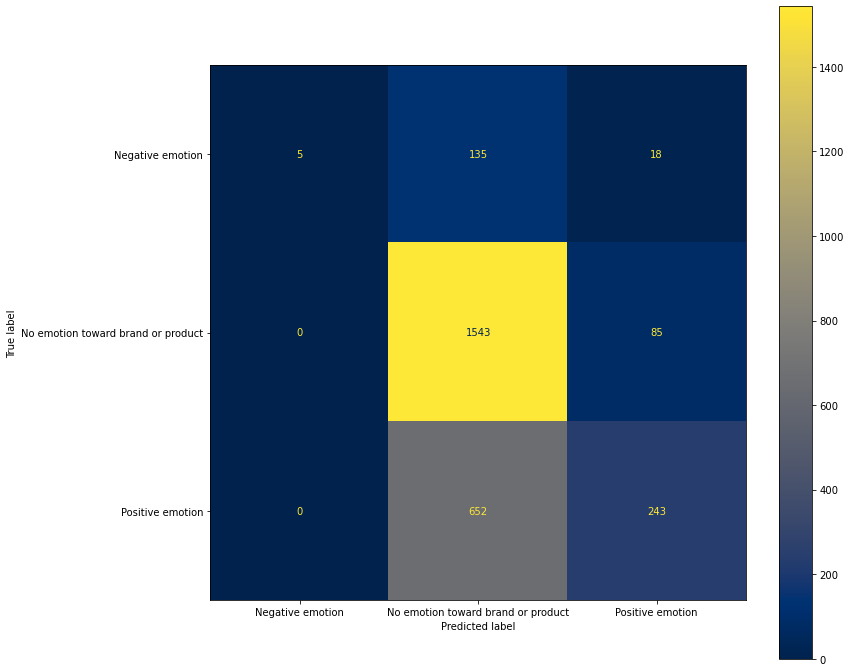

In [30]:
nb2 = MultinomialNB()

nb2.fit(tf_idf_train, y_train)

fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(nb2, tf_idf_test, y_test, ax=ax, cmap="cividis");

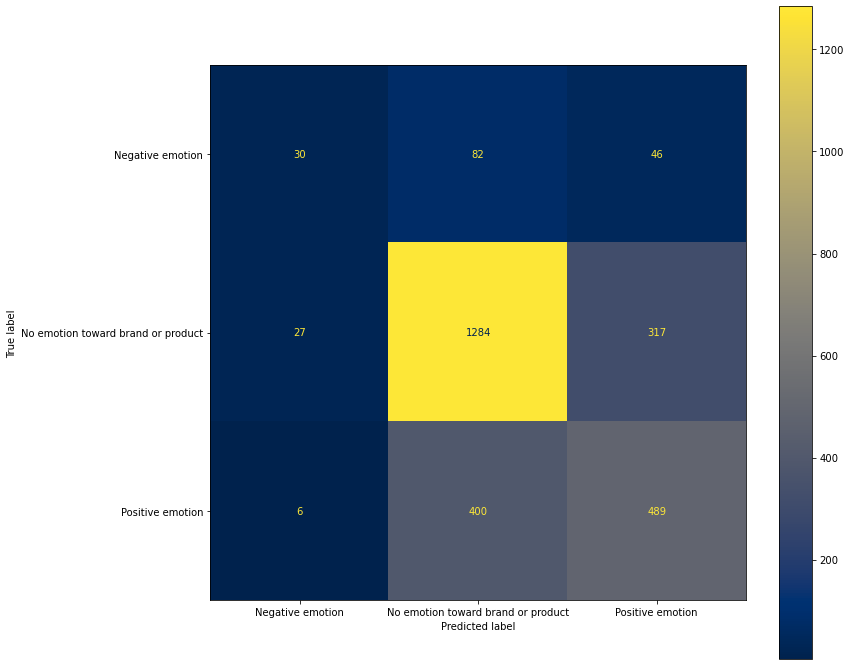

In [29]:
nb2 = MultinomialNB()

nb2.fit(X_train_vectorized2, y_train)

fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(nb2, X_test_vectorized2, y_test, ax=ax, cmap="cividis");